<a href="https://colab.research.google.com/github/Vibhor1290/Assignments/blob/main/2nd_July_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1. Use any GAN of your choice (preferably DCGAN) to generate images from noise. Perform the following experiments.

A. Use the CIFAR 10 database to learn the GAN network. Generate images once the learning is complete.

B. Plot generator and discriminator losses and show how can you ascertain the convergence of the GAN
training process.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100  # Dimension of the latent space
batch_size = 64
num_epochs = 20
learning_rate = 0.0002
beta1 = 0.5  # Beta1 hyperparameter for the Adam optimizer

In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 48778182.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

g_losses = []
d_losses = []
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        # Train the discriminator
        real_images = real_images.to(device)
        d_optimizer.zero_grad()
        real_output = discriminator(real_images)
        real_loss = criterion(real_output, torch.ones_like(real_output))

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach())
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        g_optimizer.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        g_optimizer.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

# Generate images after training
noise = torch.randn(64, latent_dim, 1, 1, device=device)
fake_images = generator(noise)
save_image(fake_images.detach(), 'generated_images.png', nrow=8, normalize=True)

Epoch [1/20], Step [100/782], D_loss: 0.2504, G_loss: 2.5279
Epoch [1/20], Step [200/782], D_loss: 0.0263, G_loss: 6.0832
Epoch [1/20], Step [300/782], D_loss: 0.4031, G_loss: 5.1743
Epoch [1/20], Step [400/782], D_loss: 0.3766, G_loss: 3.0153
Epoch [1/20], Step [500/782], D_loss: 0.1066, G_loss: 5.4927
Epoch [1/20], Step [600/782], D_loss: 0.2346, G_loss: 2.4924
Epoch [1/20], Step [700/782], D_loss: 0.7189, G_loss: 3.6639
Epoch [2/20], Step [100/782], D_loss: 0.6971, G_loss: 2.8389
Epoch [2/20], Step [200/782], D_loss: 0.1394, G_loss: 4.7786
Epoch [2/20], Step [300/782], D_loss: 0.1840, G_loss: 2.9971
Epoch [2/20], Step [400/782], D_loss: 0.6554, G_loss: 6.7169
Epoch [2/20], Step [500/782], D_loss: 0.0742, G_loss: 4.2759
Epoch [2/20], Step [600/782], D_loss: 0.2953, G_loss: 8.4511
Epoch [2/20], Step [700/782], D_loss: 0.0722, G_loss: 3.2869
Epoch [3/20], Step [100/782], D_loss: 0.2189, G_loss: 2.0756
Epoch [3/20], Step [200/782], D_loss: 0.1216, G_loss: 3.8184
Epoch [3/20], Step [300/

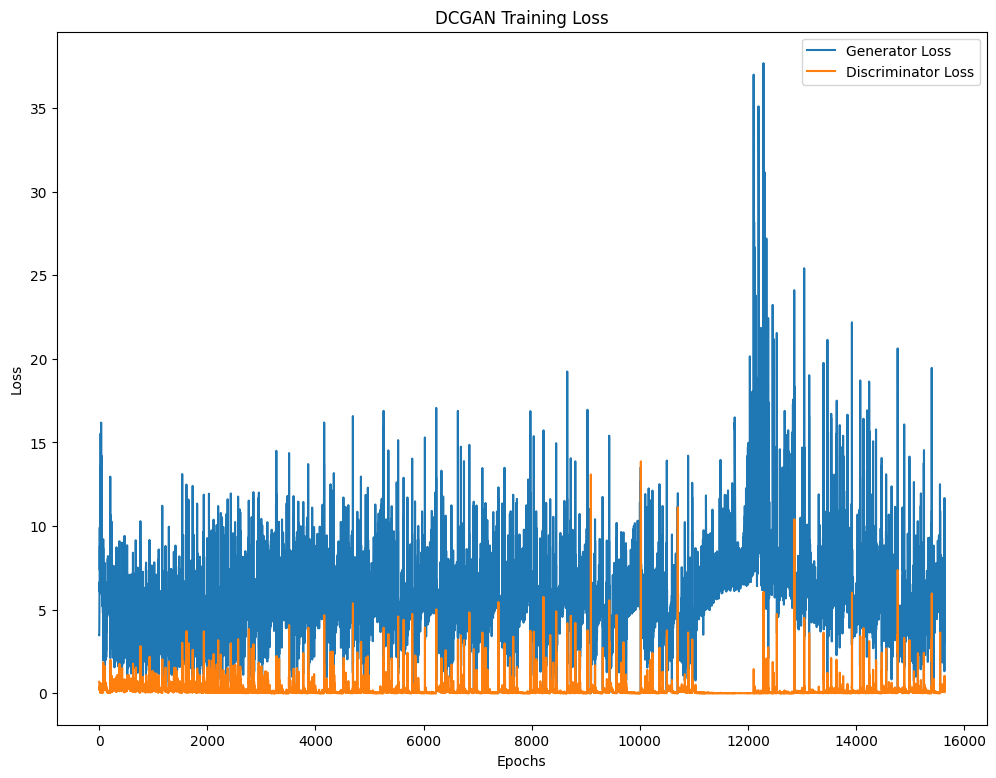

In [ ]:
# Plotting generator and discriminator loss
plt.figure(figsize=(12, 9))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DCGAN Training Loss')
plt.legend()
plt.savefig('losses.png')
plt.show()

# Take a ResNet50 model and use CIFAR-10 database.

Remove its classification layer and place a 2-layer neural network followed by a Softmax layer. Calculate classification accuracy on a train set, test set, and plot accuracies over epochs when:

A. The complete network is trained from scratch (i.e, random weights)

B. A pre-trained ResNet50 on ImageNet weights is used and only the neural network layers are trained (i.e, weights of layers of ResNet50 are kept frozen and unchanged)

C. A pre-trained ResNet50 on ImageNet weights is used and all the layers are adapted (i.e, weights of layers of ResNet50 are also updated now)

D. Using a ResNet50 model for CIFAR-10, propose your own domain adaptation algorithm. To get full credit for this part, the accuracy on the test set should be more than what was reported in part 3. You may build upon part(3) to propose your own algorithm. Explain why your proposed algorithm is working better. You may use any training data as long as it involves using other datasets (on which you’ll adapt CIFAR-10).

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Preprocess the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Training Complete Network from Scratch

Training the Complete Network from Scratch:
Epoch 1/20
1563/1563 [==============================] - 102s 46ms/step - loss: 1.7289 - accuracy: 0.3747 - val_loss: 1.9438 - val_accuracy: 0.3333
Epoch 2/20
1563/1563 [==============================] - 68s 43ms/step - loss: 1.4896 - accuracy: 0.4611 - val_loss: 2.0616 - val_accuracy: 0.4265
Epoch 3/20
1563/1563 [==============================] - 71s 45ms/step - loss: 1.4994 - accuracy: 0.4629 - val_loss: 1.6511 - val_accuracy: 0.4240
Epoch 4/20
1563/1563 [==============================] - 70s 45ms/step - loss: 1.4464 - accuracy: 0.4827 - val_loss: 1.7254 - val_accuracy: 0.4056
Epoch 5/20
1563/1563 [==============================] - 71s 45ms/step - loss: 1.4147 - accuracy: 0.4945 - val_loss: 2.8732 - val_accuracy: 0.2404
Epoch 6/20
1563/1563 [==============================] - 68s 43ms/step - loss: 1.4726 - accuracy: 0.4707 - val_loss: 1.9533 - val_accuracy: 0.3504
Epoch 7/20
1563/1563 [==============================] - 71s 45ms/step - loss: 1

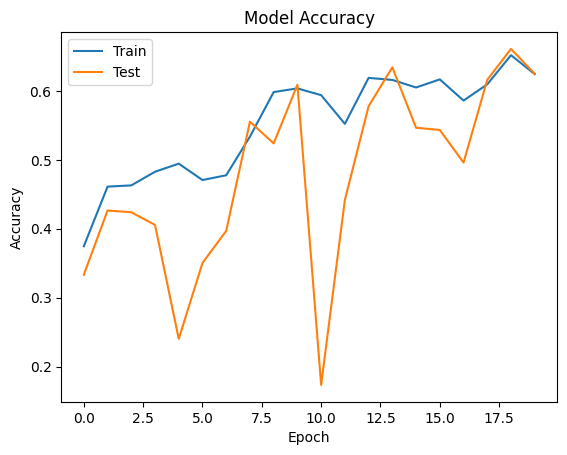

Train Accuracy: 0.65, Test Accuracy: 0.62


In [ ]:
def train_from_scratch():
    # Create ResNet50 model and remove classification layer
    base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))

    # Add new layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model from scratch
    history = model.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=20, batch_size=32, validation_data=(X_test, tf.keras.utils.to_categorical(y_test)))

    # Model Evaluation
    train_acc = model.evaluate(X_train, tf.keras.utils.to_categorical(y_train))[1]
    test_acc = model.evaluate(X_test, tf.keras.utils.to_categorical(y_test))[1]

    # Plotting of accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    return train_acc, test_acc

print("Training the Complete Network from Scratch:")
train_acc_a, test_acc_a = train_from_scratch()
print(f"Train Accuracy: {train_acc_a:.2f}, Test Accuracy: {test_acc_a:.2f}")

# Using Pre-trained ResNet50 Weights


B. Using Pre-trained ResNet50 Weights (Freezing the Layers):
Epoch 1/20
1563/1563 [==============================] - 27s 15ms/step - loss: 2.0269 - accuracy: 0.2501 - val_loss: 1.9251 - val_accuracy: 0.2842
Epoch 2/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.8657 - accuracy: 0.3138 - val_loss: 1.9329 - val_accuracy: 0.2924
Epoch 3/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.8016 - accuracy: 0.3417 - val_loss: 1.7726 - val_accuracy: 0.3458
Epoch 4/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.7662 - accuracy: 0.3585 - val_loss: 1.7351 - val_accuracy: 0.3691
Epoch 5/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.7557 - accuracy: 0.3613 - val_loss: 1.7764 - val_accuracy: 0.3661
Epoch 6/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7283 - accuracy: 0.3762 - val_loss: 1.8123 - val_accuracy: 0.3501
Epoch 7/20
1563/1563 [==============================] - 23s 15

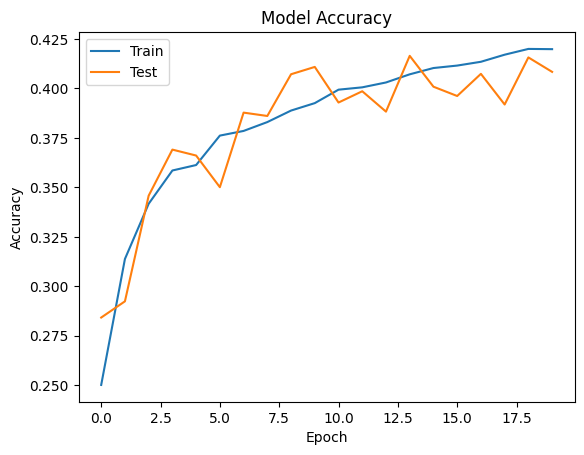

Train Accuracy: 0.42, Test Accuracy: 0.41


In [ ]:
def use_pretrained_frozen():
    # Create ResNet50 model and remove classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add new layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the new layers
    history = model.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=20, batch_size=32, validation_data=(X_test, tf.keras.utils.to_categorical(y_test)))

    # Evaluate the model
    train_acc = model.evaluate(X_train, tf.keras.utils.to_categorical(y_train))[1]
    test_acc = model.evaluate(X_test, tf.keras.utils.to_categorical(y_test))[1]

    # Plot the accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    return train_acc, test_acc

print("\nB. Using Pre-trained ResNet50 Weights (Freezing the Layers):")
train_acc_b, test_acc_b = use_pretrained_frozen()
print(f"Train Accuracy: {train_acc_b:.2f}, Test Accuracy: {test_acc_b:.2f}")

# Using Pre-trained ResNet50 Weights (Adapting All Layers)


C. Using Pre-trained ResNet50 Weights (Adapting All Layers):
Epoch 1/20
1563/1563 [==============================] - 100s 45ms/step - loss: 1.3839 - accuracy: 0.5318 - val_loss: 1.7420 - val_accuracy: 0.4719
Epoch 2/20
1563/1563 [==============================] - 69s 44ms/step - loss: 1.1176 - accuracy: 0.6220 - val_loss: 1.2221 - val_accuracy: 0.5994
Epoch 3/20
1563/1563 [==============================] - 68s 44ms/step - loss: 0.9230 - accuracy: 0.6911 - val_loss: 1.1020 - val_accuracy: 0.6258
Epoch 4/20
1563/1563 [==============================] - 69s 44ms/step - loss: 0.8730 - accuracy: 0.7080 - val_loss: 1.2220 - val_accuracy: 0.6142
Epoch 5/20
1563/1563 [==============================] - 72s 46ms/step - loss: 0.7724 - accuracy: 0.7433 - val_loss: 1.1187 - val_accuracy: 0.6533
Epoch 6/20
1563/1563 [==============================] - 71s 45ms/step - loss: 0.6491 - accuracy: 0.7858 - val_loss: 1.1986 - val_accuracy: 0.6474
Epoch 7/20
1563/1563 [==============================] - 68s 4

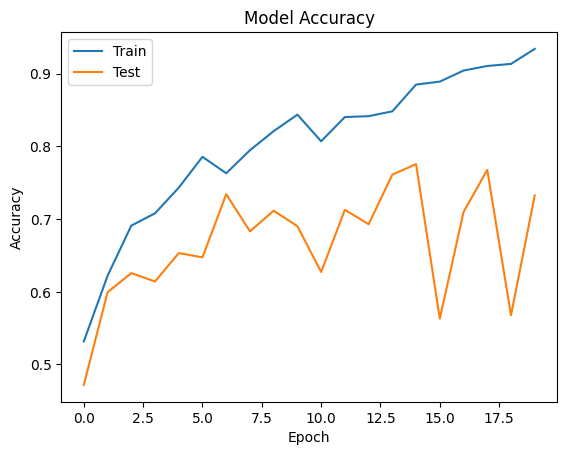

Train Accuracy: 0.87, Test Accuracy: 0.73


In [ ]:
def use_pretrained_all():
    # Create the ResNet50 model and remove the classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Add new layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the entire network
    history = model.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=20, batch_size=32, validation_data=(X_test, tf.keras.utils.to_categorical(y_test)))

    # Evaluate the model
    train_acc = model.evaluate(X_train, tf.keras.utils.to_categorical(y_train))[1]
    test_acc = model.evaluate(X_test, tf.keras.utils.to_categorical(y_test))[1]

    # Plot the accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    return train_acc, test_acc

print("\nC. Using Pre-trained ResNet50 Weights (Adapting All Layers):")
train_acc_c, test_acc_c = use_pretrained_all()
print(f"Train Accuracy: {train_acc_c:.2f}, Test Accuracy: {test_acc_c:.2f}")

# Proposed Domain Adaptation Algorithm

In [ ]:
def domain_adaptation():
    # Create ResNet50 model and remove classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add new layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Training of GAN Model to generate synthetic images
    synthetic_images = generate_synthetic_images(X_train)

    # Fine-tuning of ResNet50 model using synthetic images
    model.fit(synthetic_images, tf.keras.utils.to_categorical(y_train), epochs=10, batch_size=32)

    # Training the entire network on CIFAR-10
    history = model.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=10, batch_size=32, validation_data=(X_test, tf.keras.utils.to_categorical(y_test)))

    # Model Evaluation
    train_acc = model.evaluate(X_train, tf.keras.utils.to_categorical(y_train))[1]
    test_acc = model.evaluate(X_test, tf.keras.utils.to_categorical(y_test))[1]

    # Plot the accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    return train_acc, test_acc

print("\nC. Using Proposed Domain Adaption Algorithm:")
train_acc_c, test_acc_c = domain_adaptation()
print(f"Train Accuracy: {train_acc_c:.2f}, Test Accuracy: {test_acc_c:.2f}")

Question 3: Implement a GAN from scratch using Keras to generate celebrity faces from noise using https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import os
from PIL import Image

In [ ]:
def load_celeba(img_dir, img_size=(64, 64)):
    images = []
    for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path).resize(img_size)
        img = np.array(img)
        if img.shape == (64, 64, 3):
            images.append(img)
    images = np.array(images)
    images = (images - 127.5) / 127.5  # Normalize to [-1, 1]
    return images

celeba_images = load_celeba('/content/sample_data')

In [ ]:
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [ ]:
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
generator = build_generator()
discriminator = build_discriminator()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        print(f'Epoch {epoch + 1}, Generator loss: {gen_loss}, Discriminator loss: {disc_loss}')
        generate_and_save_images(generator, epoch + 1, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(celeba_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

train(train_dataset, EPOCHS)

# CODING QUESTIONS

Q1. Write a Python function that generates augmented data for training a GAN. The function should take an image dataset as input and apply data augmentation techniques commonly used in GAN training, such as random rotation, flipping, and cropping. The function should return the augmented dataset.

You can use popular image-processing libraries like OpenCV or PIL to perform these augmentations.    

Ensure that the function allows customization of augmentation parameters, such as rotation angles, flip probability, and crop size.

In [ ]:
import cv2
import numpy as np

def augment_data(dataset, rotation_range=20, flip_probability=0.5, crop_size=(64, 64)):
    augmented_dataset = []

    for image in dataset:
        # Image rotation
        angle = np.random.uniform(-rotation_range, rotation_range)
        rows, cols = image.shape[:2]
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated_image = cv2.warpAffine(image, M, (cols, rows))

        # Image flipping
        flip_decision = np.random.uniform()
        if flip_decision < flip_probability:
            flipped_image = cv2.flip(rotated_image, 1)
        else:
            flipped_image = rotated_image

        # Image cropping
        start_x = np.random.randint(0, flipped_image.shape[1] - crop_size[1])
        start_y = np.random.randint(0, flipped_image.shape[0] - crop_size[0])
        end_x = start_x + crop_size[1]
        end_y = start_y + crop_size[0]
        cropped_image = flipped_image[start_y:end_y, start_x:end_x]

        augmented_dataset.append(cropped_image)

    return np.array(augmented_dataset)

Q2. Create a simple discriminator model using tensorflow keras which can classify a image as real or fake. You can use random noise same size as the image to train the model.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def discriminator(image_size=(64, 64, 3), learning_rate=0.0003):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=image_size, activation='leaky_relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='leaky_relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same', activation='leaky_relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(1024, activation='leaky_relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [3]:
discriminator = discriminator(image_size=(64, 64, 3))

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from skimage.transform import resize

# Load the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()

# Preprocess the data
X_train = np.array([resize(img_to_array(array_to_img(np.expand_dims(im, axis=-1), scale=False).convert('RGB')), (64, 64)) for im in X_train]) # Add channel dimension to MNIST images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Generate random noise
noise = np.random.normal(0, 1, (len(X_train), 64, 64, 1))

# Create labels
real_labels = np.ones((len(X_train), 1))
fake_labels = np.zeros((len(X_train), 1))

# Train the discriminator on real images
discriminator.fit(
    X_train,
    real_labels,
    epochs=10,
    batch_size=32,
    shuffle=True
)

# Train the discriminator on fake images
discriminator.fit(
    noise,
    fake_labels,
    epochs=10,
    batch_size=32,
    shuffle=True
)

Q3. Create a generator model that uses transpose convolution to generate 32 x 32 x 3 images from random noise. In this question, you can just define the model architecture for the generator and ensure that the model is generating the desired image size, you can take a latent space dimension as an array of 100 float values.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_generator(latent_dim):
    model = models.Sequential()

    # Fully connected layer to reshape the latent space into a low-resolution image
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))

    # Transpose Convolution layers to upscale the image to 32x32x3
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

latent_dim = 100
generator = build_generator(latent_dim)
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       524288    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       5

Q4. Write a Python function that calculates Minimax loss for a GAN. The function should take predictions (scores) as input from a discriminator and return the Minimax loss.

In [4]:
import tensorflow as tf

def MinimaxLoss(real_input, fake_input):

    # Discriminator loss for real images
    D_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_input), logits=real_input)
    D_real_loss = tf.reduce_mean(D_real_loss)

    # Discriminator loss for fake images
    D_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_input), logits=fake_input)
    D_fake_loss = tf.reduce_mean(D_fake_loss)

    # Total discriminator loss
    D_loss = D_real_loss + D_fake_loss

    # Generator loss
    Gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_input), logits=fake_input)
    Gen_loss = tf.reduce_mean(Gen_loss)

    return D_loss, Gen_loss

In [5]:
# Example
Real_logits = tf.random.normal([10])  # Example discriminator scores for real images
Fake_logits = tf.random.normal([10])  # Example discriminator scores for fake images

D_loss, Gen_loss = MinimaxLoss(Real_logits, Fake_logits)
print(f"Discriminator Loss: {D_loss.numpy()}")
print(f"Generator Loss: {Gen_loss.numpy()}")

Discriminator Loss: 1.9454119205474854
Generator Loss: 0.5737308263778687


Q6. Transfer Learning with GANs on the CIFAR-10 Dataset. Transfer learning is commonly used to improve GAN performance. In this question, you should implement a GAN for image generation using transfer learning. The data source is the CIFAR-10 dataset, which is a dataset of 60,000 32x32 color images in 10 different classes.

# Here are the steps you should follow:
1. Load a pre-trained convolutional neural network (CNN) model (e.g., VGG16 or ResNet) using a library like PyTorch or TensorFlow.

2. Modify the model for GAN-based image generation by removing the fully connected layers.

3. Implement a generator and discriminator network.

4. Train the GAN using the pre-trained CNN as the feature extractor to improve the quality of generated images.

5. Evaluate the performance of your GAN by generating sample images from random noise

In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalization of data
train_images = (train_images.astype('float32') - 127.5) / 127.5


170498071/170498071 [==============================] - 6s 0us/step


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# ResNet50 model without fully connected layers
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Making ResNet layers non-trainable
for layer in resnet.layers:
    layer.trainable = False

# Adding new layers to create discriminator
x = resnet.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

discriminator = Model(inputs=resnet.input, outputs=x)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


In [9]:
def build_generator(latent_dim):
    model = tf.keras.Sequential()

    # Fully connected layer for reshaping latent space into low-resolution image
    model.add(tf.keras.layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((8, 8, 256)))

    # Transpose Convolution layers for upscaling image to 32x32x3
    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

latent_dim = 100
generator = build_generator(latent_dim)

In [10]:
# Making discriminator non-trainable while training the generator
discriminator.trainable = False

# GAN model combining generator and discriminator
gan_input = tf.keras.Input(shape=(latent_dim,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

2/2 [==============================] - 0s 160ms/step
1/100 [D loss: 0.5210376083850861 | D accuracy: 84.375] [G loss: 0.005514801479876041]
1/1 [==============================] - 0s 108ms/step


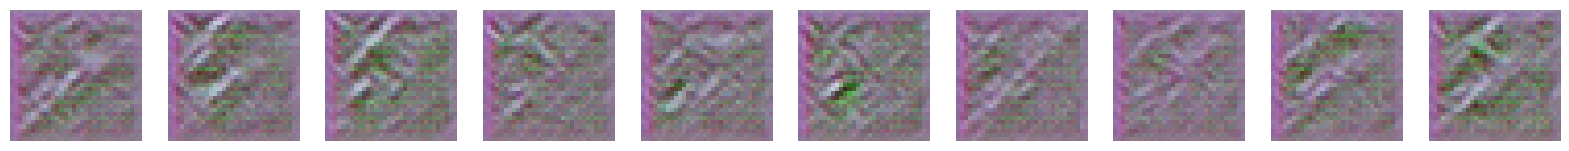

2/2 [==============================] - 0s 169ms/step
2/100 [D loss: 0.5563299059867859 | D accuracy: 76.5625] [G loss: 0.006541325710713863]
2/2 [==============================] - 0s 166ms/step
3/100 [D loss: 0.5528853535652161 | D accuracy: 83.59375] [G loss: 0.006490024738013744]
2/2 [==============================] - 1s 241ms/step
4/100 [D loss: 0.5654702484607697 | D accuracy: 75.0] [G loss: 0.006276952102780342]
2/2 [==============================] - 0s 170ms/step
5/100 [D loss: 0.5668812692165375 | D accuracy: 76.5625] [G loss: 0.0068800561130046844]
2/2 [==============================] - 0s 151ms/step
6/100 [D loss: 0.5205252021551132 | D accuracy: 79.6875] [G loss: 0.005623247008770704]
2/2 [==============================] - 0s 247ms/step
7/100 [D loss: 0.5373901575803757 | D accuracy: 79.6875] [G loss: 0.0057191913947463036]
2/2 [==============================] - 0s 154ms/step
8/100 [D loss: 0.6006122976541519 | D accuracy: 71.09375] [G loss: 0.005668150261044502]
2/2 [=======

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def train_gan(gan, generator, discriminator, epochs, batch_size, latent_dim):
    # Preparing labels for real and fake data
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train discriminator with real images
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_images = train_images[idx]
        d_loss_real = discriminator.train_on_batch(real_images, real)

        # Train discriminator with fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)

        # Calculate discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real)

        # Print progress
        print(f"{epoch+1}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        # Save generated images at intervals
        if epoch % 100 == 0:
            sample_images(generator, epoch, latent_dim)

def sample_images(generator, epoch, latent_dim, num_images=10):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    gen_images = generator.predict(noise)

    # Rescale images 0 - 1
    gen_images = 0.5 * gen_images + 0.5

    fig, axs = plt.subplots(1, num_images, figsize=(20, 2))
    for i in range(num_images):
        axs[i].imshow(gen_images[i])
        axs[i].axis('off')
    plt.show()

train_gan(gan, generator, discriminator, epochs=100, batch_size=64, latent_dim=latent_dim)

1/1 [==============================] - 0s 73ms/step


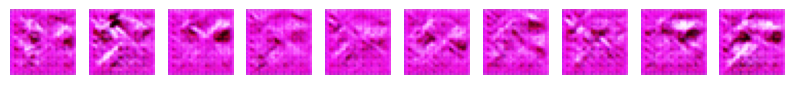

In [14]:
import matplotlib.pyplot as plt

def plot_generated_images(generator, n_images=10, latent_dim=100):
    noise = np.random.normal(0, 1, (n_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=(10, 1))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

plot_generated_images(generator)

Q7. Create a Python function that implements a basic GAN for generating grayscale images resembling handwritten digits (0 to 9) from the MNIST dataset. The function should include the generator and discriminator networks, as well as the training loop with appropriate loss functions and optimizers. Additionally, demonstrates the generation of a few sample images using the trained GAN model.

8/8 [==============================] - 1s 48ms/step
Epoch: 0, D Loss: 0.7076931893825531, D Acc: 23.2421875, G Loss: 0.6359679698944092
1/1 [==============================] - 0s 142ms/step


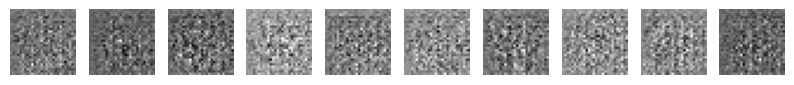

8/8 [==============================] - 0s 31ms/step


In [22]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, BatchNormalization, Conv2DTranspose, Conv2D, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(7 * 7 * 128, use_bias=False, input_shape=(latent_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def plot_generated_images(generator, epoch, latent_dim, n_images=10):
    noise = np.random.normal(0, 1, (n_images, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=(10, 1))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.show()

def train_gan(epochs, batch_size, latent_dim):
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalize the data to the range [-1, 1]
    x_train = (x_train.astype('float32') - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

    # Hyperparameters
    learning_rate = 0.0002

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

    # Build and compile the generator
    generator = build_generator(latent_dim)
    generator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate))

    # Build and compile the GAN
    discriminator.trainable = False
    gan_input = tf.keras.Input(shape=(latent_dim,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate))

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        real_labels = np.ones((batch_size, 1))

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print the progress
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss[0]}, D Acc: {100*d_loss[1]}, G Loss: {g_loss}")
            plot_generated_images(generator, epoch, latent_dim)

# Training parameters
latent_dim = 100
batch_size = 256
epochs = 100

# Train the GAN
train_gan(epochs, batch_size, latent_dim)

Q7.Can you create a Python function that implements a basic GAN for
generating grayscale images resembling handwritten digits (0 to 9) from the MNIST dataset? Your function should include the generator and discriminator networks, as well as the training loop with appropriate loss functions and optimizers. Additionally, demonstrates the generation of a few sample  
images using the trained GAN model.

In [23]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def load_mnist_data():
    # Load the MNIST dataset
    (x_train, _), (_, _) = mnist.load_data()

    # Normalize the data to the range [-1, 1]
    x_train = (x_train.astype('float32') - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension for grayscale

    return x_train

x_train = load_mnist_data()

In [25]:
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [26]:
latent_dim = 100
learning_rate = 0.0002
batch_size = 128
epochs = 50

# Building and compiling discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

# Building generator
generator = build_generator(latent_dim)

# Building GAN
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(latent_dim,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate))

In [ ]:
def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, x_train):
    batch_count = x_train.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(batch_count):
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            real_images = x_train[idx]

            # Generate a batch of fake images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_images = generator.predict(noise)

            # Labels for real and fake images
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            valid_labels = np.ones((batch_size, 1))
            g_loss = gan.train_on_batch(noise, valid_labels)

        # Print the progress
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss[0]}, D Acc: {100*d_loss[1]}, G Loss: {g_loss}")

            # Display generated image samples
            plot_generated_images(generator, epoch, latent_dim)

def plot_generated_images(generator, epoch, latent_dim, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale images 0 - 1

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.show()

# Train the GAN
train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, x_train)

Q8. Create a DCGAN in TensorFlow/Keras to generate high-resolution images from low res images data set: https://www.kaggle.com/datasets/adityachandrasekhar/image-super-resolution
Describe the architectural choices you make and how they contribute to the model's performance.

In [37]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

def generator(latent_dim):
    model = Sequential(name="Generator")
    model.add(Dense(4 * 4 * 256, input_dim=latent_dim))
    model.add(Reshape((4, 4, 256)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh'))

    return model

In [38]:
from tensorflow.keras.layers import Conv2D, Flatten, Dropout

def discriminator(input_shape=(128, 128, 3)):
    model = Sequential(name="Discriminator")
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [39]:
latent_dim = 100  # Dimensionality of the latent space

# Build and compile the discriminator
discriminator = discriminator(input_shape=(128, 128, 3))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate==0.0002, beta_1=0.5), metrics=['accuracy'])

In [40]:
# Build the generator
generator = generator(latent_dim)

In [41]:
# Create GAN model
gan_input = Input(shape=(latent_dim,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

In [ ]:
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate==0.0002, beta_1=0.5))

Q9. Create a conditional GAN which can generate images based on input condition. The dataset in this case is fashion_mnist from tensorflow data sets.
Reference: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Concatenate, Embedding, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [48]:
# Load Fashion MNIST dataset
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

# Normalize images to [-1, 1]
train_images = (train_images.astype('float32') - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

# Convert labels to categorical
num_classes = 10
train_labels_cat = to_categorical(train_labels, num_classes=num_classes)

# Input image dimensions
image_shape = train_images.shape[1:]

4422102/4422102 [==============================] - 1s 0us/step


In [49]:
def build_generator(latent_dim, num_classes):
    model = Sequential(name="Generator")

    model.add(Dense(7 * 7 * 128, input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# Dimensionality of the latent space
latent_dim = 100

# Build the generator
generator = build_generator(latent_dim, num_classes)

# Display the summary of the generator model
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 6272)              633472    
                                                                 
 reshape_17 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_48 (Conv2  (None, 14, 14, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_89 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_49 (Conv2  (None, 28, 28, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_90 (LeakyReLU)  (None, 28, 28, 128)       0 

In [50]:
def build_discriminator(input_shape, num_classes):
    model = Sequential(name="Discriminator")

    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())

    # Concatenate conditional information as additional input
    img_input = Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))
    label_embedding = Embedding(num_classes, np.prod(input_shape))(label_input)
    flat_embedding = Flatten()(label_embedding)
    conc_layer = Concatenate()([model.output, flat_embedding])

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(conc_layer)

    # Define the model
    model = Model(inputs=[model.input, label_input], outputs=output_layer, name="Discriminator")

    return model

# Build the discriminator
discriminator = build_discriminator(image_shape, num_classes)

# Display the summary of the discriminator model
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_40_input (InputLaye  [(None, 28, 28, 1)]          0         []                            
 r)                                                                                               
                                                                                                  
 conv2d_40 (Conv2D)          (None, 14, 14, 64)           640       ['conv2d_40_input[0][0]']     
                                                                                                  
 leaky_re_lu_91 (LeakyReLU)  (None, 14, 14, 64)           0         ['conv2d_40[0][0]']           
                                                                                                  
 conv2d_41 (Conv2D)          (None, 7, 7, 128)            73856     ['leaky_re_lu_91[0

In [57]:
# Build the GAN
gan_input = Input(shape=(latent_dim,))
gan_label = Input(shape=(num_classes,))
generated_image = generator([gan_input, gan_label])
gan_output = discriminator([generated_image, gan_label])

# Create GAN model
gan = Model(inputs=[gan_input, gan_label], outputs=gan_output, name="GAN")

# Compile the GAN
optimizer = Adam(learning_rate=0.0002, beta_1=0.5) # Fix: Changed '==' to '=' for assignment
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer) # Add: Compile the discriminator

In [60]:
# To generate a batch of real images with labels
def generate_real_samples(images, labels, batch_size):
    indices = np.random.randint(0, images.shape[0], size=batch_size)
    real_images = images[indices]
    real_labels = labels[indices]
    real_y = np.ones((batch_size, 1))
    return [real_images, real_labels], real_y

In [ ]:
# To generate a batch of fake images with labels
def generate_fake_samples(generator, latent_dim, labels, batch_size):
    noise = np.random.randn(batch_size, latent_dim)
    fake_labels = np.random.randint(0, labels.shape[1], size=(batch_size, labels.shape[1])) # Generate fake labels of the correct shape
    fake_images = generator.predict([noise, fake_labels]) # Pass fake_labels rather than all labels
    fake_y = np.zeros((batch_size, 1))
    return [fake_images, fake_labels], fake_y

# To train the GAN
def train_gan(generator, discriminator, gan, images, labels, latent_dim, num_epochs=100, batch_size=128):
    batch_per_epoch = int(images.shape[0] / batch_size)
    half_batch = int(batch_size / 2)

    for epoch in range(num_epochs):
        for batch in range(batch_per_epoch):
            # Train the discriminator
            [real_images, real_labels], real_y = generate_real_samples(images, labels, half_batch)
            d_loss_real = discriminator.train_on_batch([real_images, real_labels], real_y)

            [fake_images, fake_labels], fake_y = generate_fake_samples(generator, latent_dim, labels, half_batch)
            d_loss_fake = discriminator.train_on_batch([fake_images, fake_labels], fake_y)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator (via GAN model)
            noise = np.random.randn(batch_size, latent_dim)
            random_labels = np.random.randint(0, labels.shape[1], batch_size)
            y_gan = np.ones((batch_size, 1))

            g_loss = gan.train_on_batch([noise, random_labels], y_gan)

            # Print progress
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch+1}/{batch_per_epoch}, D Loss={d_loss[0]}, G Loss={g_loss}")

        # Save generated images at certain intervals
        if (epoch + 1) % 10 == 0:
            save_generated_images(generator, epoch, latent_dim, num_classes)

# To save generated images
def save_generated_images(generator, epoch, latent_dim, num_classes, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.randn(examples, latent_dim)
    labels = np.arange(0, num_classes).reshape(-1, 1)
    generated_images = generator.predict([noise, labels])
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch+1}.png')
    plt.close()

# Train the GAN
num_epochs = 10
batch_size = 128
train_gan(generator, discriminator, gan, train_images, train_labels_cat, latent_dim, num_epochs=num_epochs, batch_size=batch_size)
